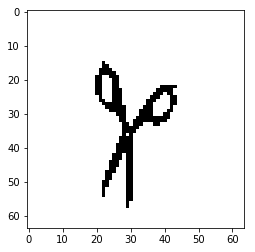

In [226]:
import numpy as np
from scipy.fftpack import dct 
from scipy.fftpack import idct 
from scipy.misc import imread
from skimage.util.shape import view_as_blocks
import matplotlib.pyplot as plot
from math import floor

block_size = 16
k = 32
offset = 10
q = 18

def embed_watermark(watermark, image):
    
    green_channel = np.array(image[:,:,1])
    
    watermark = watermark[:,:,1].flatten()/255
    watermark_position = 0
    
    for block_row in range(green_channel.shape[0] // block_size):
        for block_column in range(green_channel.shape[1] // block_size):
                
            block = green_channel[block_row * block_size : (block_row + 1) * block_size, 
                                  block_column * block_size : (block_column + 1) * block_size]
            dct_coef = dct2(block)    
            zz_coef = zigzag(dct_coef)    
            
            for i in range(k):
                if (watermark_position >= watermark.size): watermark_position = 0
                zz_coef[offset + i] = embed_formula(zz_coef[offset + i], watermark[watermark_position])        
                watermark_position += 1
            
            dct_coef = unzigzag(zz_coef)
            green_channel[block_row * block_size : (block_row + 1) * block_size, 
                          block_column * block_size : (block_column + 1) * block_size] = idct2(dct_coef)
            
    image[:,:,1] = green_channel
    return image

def extract_watermark(image, watermark_shape):
    
    green_channel = np.array(image[:,:,1])
    
    watermark = np.array([])
    watermark_size = watermark_shape[0] * watermark_shape[1]
    
    for block_row in range(green_channel.shape[0] // block_size):
        for block_column in range(green_channel.shape[1] // block_size):
                
            block = green_channel[block_row * block_size : (block_row + 1) * block_size, 
                                  block_column * block_size : (block_column + 1) * block_size]
            dct_coef = dct2(block)    
            zz_coef = zigzag(dct_coef)
            for i in range(k):
                watermark = np.append(watermark, extract_formula(zz_coef[offset + i]))
            
    watermark = watermark.reshape(-1, watermark_size)
    times_watermark_inserted = watermark.shape[0]
    watermark = np.round(np.sum(watermark, axis=0) / times_watermark_inserted)
    return watermark.reshape(watermark_shape) * 255

def zigzag_indices(n):
    path = []
    
    for k in range(2*n-1):
        for i in range(n):
            for j in range(n):
                if i+j==k:
                    if k%2==0:
                        path += [(i,j)]
                    else: 
                        path += [(j,i)]
                
    return path

def zigzag(matrix):
    indices = zigzag_indices(matrix.shape[0])
    return [matrix[index] for index in indices]

def unzigzag(vector):
    n = int(np.sqrt(len(vector)))
    matrix = np.zeros((n,n))
    indices = zigzag_indices(int(n))
    for i in range(len(indices)):
        matrix[indices[i]] = vector[i]
    return matrix   

def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

def idct2(coefficients):
    return idct(idct(coefficients.T, norm='ortho').T, norm='ortho')

def embed_formula(c, w):
    return np.floor(c / q) * q + q / 2 * w * np.sign(c - np.floor(c / q) * q) 

def extract_formula(c):
    return np.round(c / (q / 2)) % 2
    
image = embed_watermark(imread('patterns/01_01.gif'), imread('Lenna.png'))
plot.imshow(image)
plot.show()

watermark = extract_watermark(image, (64, 64))
plot.imshow(watermark, cmap='gray')
plot.show()